# Torch
## Check GPU¶

In [1]:
import torch
import numpy as np
import sys
sys.path.append('..')

from torchlib.utils import list_device,set_device

# S1: check GPU
#list_device()

# S2: default parameters
set_device(1)
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


Using Device 1 : TITAN Xp


In [2]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()

'''Training Parameters'''
parser.add_argument('--batch_size', type=int, default=300, help='minibatch size')
parser.add_argument('--num_epochs', type=int, default=200, help='number of epochs')
parser.add_argument('--grad_clip', type=float, default=5., help='clip gradients at this value')
parser.add_argument('--learning_rate', type=float, default=0.008, help='learning rate')
parser.add_argument('--learning_rate_clip', type=float, default=0.0000001, help='learning rate clip')
parser.add_argument('--decay_rate', type=float, default=.7, help='decay rate for rmsprop')
parser.add_argument('--weight_decay', type=float, default=.0001, help='decay rate for rmsprop')
parser.add_argument('--batch_norm_decay', type=float, default=.999, help='decay rate for rmsprop')
parser.add_argument('--keep_prob', type=float, default=1.0, help='dropout keep probability')
parser.add_argument('--lamda_weights', type=float, default=.01, help='lamda weight')
parser.add_argument('--data_argumentation', type=bool, default=True, help='whether do data argument')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data nomalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')

'''Configure'''
parser.add_argument('--network', type=str, default='vggnet_localization')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/class_gps_torch', help='rnn, gru, or lstm')

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08',
                                                            '/notebooks/michigan_nn_data/2012_01_15',
                                                            '/notebooks/michigan_nn_data/2012_01_22',
                                                            '/notebooks/michigan_nn_data/2012_02_02',
                                                            '/notebooks/michigan_nn_data/2012_02_04',
                                                            '/notebooks/michigan_nn_data/2012_02_05',
                                                            '/notebooks/michigan_nn_data/2012_03_31',
                                                            '/notebooks/michigan_nn_data/2012_09_28'])
'''
#parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08'])
'''
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--save_every', type=int, default=500, help='save frequency')
parser.add_argument('--display', type=int, default=10, help='display frequency')
parser.add_argument('--tensorboard', type=bool, default=True, help='open tensorboard')

sys.argv = ['']
args = parser.parse_args()

if args.tensorboard:
    import os
    os.system('rm -rf runs/class_gps')
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter('runs/class_gps')

In [3]:
if args.tensorboard:
    import os
    os.system('rm -rf runs/class_gps')
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter('runs/class_gps')

# Load Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
from PIL import Image
import numpy as np
import random

import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet
from torchlib.cnn_auxiliary import normalize, denormalize_navie, denormalize, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.train_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False)

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)


dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=True, num_workers=0, \
                        drop_last=True, pin_memory=True)

100%|██████████| 14037/14037 [00:27<00:00, 514.23it/s]


Save norm and std: /notebooks/global_localization/norm_mean_std.pt


# Grid

Save Grids to /notebooks/global_localization/class_gps_torch/grid.pkl
Grid_num: 32


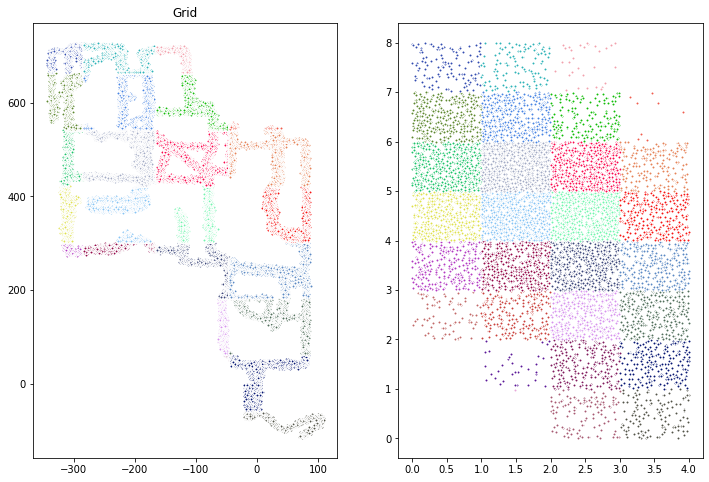

[0, 81, 6014, 6688, 0, 1684, 12157, 11692, 3907, 11678, 22050, 16120, 15195, 23808, 26643, 15774, 28546, 40556, 35890, 16194, 29094, 41899, 30930, 10022, 17844, 21176, 8700, 410, 6008, 6100, 1533, 0]


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pickle

class Grid:
    def __init__(self,grid_size=100.,overlap=50.,**kwargs):
        self.grid_size = grid_size
        self.overlap = overlap
        if 'data' in kwargs:
            data = kwargs['data']
            assert data.shape[1] == 2
            self.boundary_x = [np.min(data[:,0]), np.max(data[:,0])]
            self.boundary_y = [np.min(data[:,1]), np.max(data[:,1])]
            self.boundary_offset = [self.boundary_x[0],self.boundary_y[0]]
            self.num_grid_x,self.num_grid_y = self._cal_grid_num()
            self.num_grid = self.num_grid_x * self.num_grid_y
            self.weight = np.array([1, self.num_grid_x])
            self.weight_matrix = np.array([[1,self.num_grid_x,0,0],
                                           [1,0,0,self.num_grid_x],
                                           [0,self.num_grid_x,1,0],
                                           [0,0,1,self.num_grid_x]]).T
            self.grid_range_x,self.grid_range_y = self._cal_grid_range()
            self.save(os.path.join(args.model_dir,'grid.pkl'))
            print('Save Grids to',os.path.join(args.model_dir,'grid.pkl'))
        
    def _lenght(self):
        x_len = self.boundary_x[1] - self.boundary_x[0]
        y_len = self.boundary_y[1] - self.boundary_y[0]
        return x_len,y_len
    
    def _cal_grid_num(self):
        x_len,y_len = self._lenght()
        num_x_grid = math.ceil(x_len/self.grid_size)
        num_y_grid = math.ceil(y_len/self.grid_size)
        return num_x_grid,num_y_grid
    
    def _cal_grid_range(self):
        grid_range_x = list()
        grid_range_y = list()
        for x_inde in range(self.num_grid_x):
            x = x_inde*self.grid_size + self.boundary_x[0]
            grid_range_x.append([x-self.overlap,x+self.overlap+self.grid_size])

        for y_inde in range(self.num_grid_y):
            y = y_inde*self.grid_size + self.boundary_y[0]
            grid_range_y.append([y-self.overlap,y+self.overlap+self.grid_size])
        return np.array(grid_range_x),np.array(grid_range_y)
    
    def _grid_index(self,x,y):
        x_s = np.searchsorted(self.grid_range_x[:,1],x)
        x_s = min(max(x_s,0),self.num_grid_x-1)
        x_index = [x_s,x_s+1] if x_s+1 < self.num_grid_x and self.grid_range_x[x_s+1,0] < x else [x_s,x_s]
        
        y_s = np.searchsorted(self.grid_range_y[:,1],y)
        y_s = min(max(y_s,0),self.num_grid_y-1)
        y_index = [y_s,y_s+1] if y_s+1 < self.num_grid_y and self.grid_range_y[y_s+1,0] < y else [y_s,y_s]
        
        return x_index,y_index
    
    def in_grids(self,x,y):
        x_index,y_index = self._grid_index(x,y)
        #print(x_index,y_index)
        box = []
        for x_i in x_index:
            for y_i in y_index:
                box += [x_i+y_i*self.num_grid_x]
        return box
    
    def in_grids_exact_v(self,X):
        X = np.floor_divide(X - self.boundary_offset, self.grid_size)
        X = X @ self.weight
        return X
    
    def in_grids_v(self,X):
        X = X - self.boundary_offset
        X_l = np.floor_divide(X - self.overlap, self.grid_size)
        X_l[X_l<0] = 0
        X_h = np.floor_divide(X + self.overlap, self.grid_size)
        X_h[:,0][X_h[:,0]>=self.num_grid_x] = self.num_grid_x -1
        X_h[:,1][X_h[:,1]>=self.num_grid_y] = self.num_grid_y -1
        out = np.hstack([X_l,X_h]) @ self.weight_matrix
        return out

    def save(self,filename = 'grid.pkl'):
        with open(filename,'wb') as f:
            f.write(pickle.dumps(self))

    def load(self,filename = 'grid.pkl'):
        with open(filename,'rb') as f:
            dataPickle = f.read()
            self = pickle.loads(dataPickle)
        
def draw(X,grid,seed=args.seed):
    label_mask = grid.in_grids_v(X)
    '''
    label_mask = np.zeros([X.shape[0],4])
    for i in range(X.shape[0]):
        label_mask[i] = np.array(grid.in_grids(*X[i]))
    '''

    np.random.seed(seed)
    r = lambda: np.random.randint(0,255)
    colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(grid.num_grid)]
    fig = plt.figure(figsize=(12, 8))
    
    ax = fig.add_subplot(1, 2, 1)
    for k, col in zip(range(grid.num_grid), colors):
        my_members = np.sum(label_mask == k,axis=1) >= 1
        ax.plot(X[my_members, 0], X[my_members, 1], 'w',
                markerfacecolor=col, marker='.')
    ax.set_title('Grid')
    #plt.show()
    
    dis = []
    for i in range(grid.num_grid):
        dis += [np.sum(np.sum(label_mask == i,axis=1)>=1)]
    
    ax = fig.add_subplot(1, 2, 2)
    for i,dense in enumerate(dis):
        row,line = divmod(i,grid.num_grid_x)
        x = np.random.rand(dense//50) + line
        y = np.random.rand(dense//50) + row
        ax.plot(x, y, 'w',markerfacecolor=colors[i], marker='.')
    plt.show()
    return dis

grid = Grid(data=np.array(dataset.Targets)[:,:2],grid_size = 120., overlap=60.)
print('Grid_num:',grid.num_grid)

dis = draw(np.array(dataset.Targets)[:,:2],grid)
print(dis)

# Define Model

In [6]:
from torchlib.model import Backbone, NN, GP#, GPNode_local
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.likelihoods import BernoulliLikelihood

class BasicTrainer:
    def __init__(self,norm_mean,norm_std):
        self.model = None
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
    def disable_requires_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def load_model(self, file_name = 'pretrained.pth'):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = True)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = True)
        # Display model structure
        #print('Model Structure:')
        #for name, param in self.model.named_parameters():
        #    print(name, param.shape)
        print('Successfully loaded model...')
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def show_require_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print (name, param.shape)

class GPNode_local(nn.Module):
    def __init__(self,inducing_points):
        super(GPNode_local,self).__init__()
        output_dim = inducing_points.shape[0] # 3-dim
        feat_dim = inducing_points.shape[-1]
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output

class GPNode_global(nn.Module):
    def __init__(self,inducing_points,num_gp):
        super(GPNode_global,self).__init__()
        output_dim = inducing_points.shape[0] # num_gp
        feat_dim = inducing_points.shape[-1]
        
        self.gp = GP(inducing_points,num_gp)
        self.likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=num_gp, num_classes=num_gp)
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output

class Model(nn.Module):
    def __init__(self,num_grid):
        super().__init__()
        self.num_gp = num_grid
        # Part 1: basic NN
        self.backbone = Backbone()
        self.nn = NN()
        # Part 2: global GP
        inducing_points = torch.zeros(self.num_gp, args.batch_size, args.feat_dim)
        #inducing_points = torch.zeros(self.num_gp, 300, args.feat_dim)
        self.global_gp = GPNode_global(inducing_points,self.num_gp)
        # Part 3: local GPs
        self.local_gps = nn.ModuleList()
        for i in range(self.num_gp):
            inducing_points = torch.zeros(args.output_dim, args.batch_size, args.feat_dim)
            #inducing_points = torch.zeros(args.output_dim, 500, args.feat_dim)
            gp = GPNode_local(inducing_points)
            self.local_gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention            
        return feature_t, rot_pred
    
    def forward_gp(self,gp,trans_feat):
        trans_pred = gp(trans_feat)
        return trans_pred

In [7]:
class Trainer(BasicTrainer):
    def __init__(self, grid, norm_mean, norm_std,
                 regressor_context_rate = [0.0,0.0],
                 is_training=True, disable_rot_learning = True, 
                 train_global_gp = True, train_local_gps = True):
        
        super().__init__(norm_mean, norm_std)
        self.model = Model(grid.num_grid).cuda()
        self.disable_rot_learning = disable_rot_learning
        self.train_global_gp = train_global_gp
        self.train_local_gps = train_local_gps
        
        self.disable_requires_grad(self.model.backbone)
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
        else:
            self.disable_requires_grad(self.model)
            
    def _optimize(self,regressor_context_rate):
        optimizer = list()
        # Local GPs
        if self.train_local_gps:
            optimizer += [
                    {'params': self.model.local_gps.parameters(), \
                     'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.local_gps)
            
        # Global GP
        if self.train_global_gp:
            optimizer += [{'params': self.model.global_gp.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
        else:
            self.disable_requires_grad(self.model.global_gp)
            
        # NN
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            self.disable_requires_grad(self.model.nn.global_regressor)
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            self.disable_requires_grad(self.model.nn.global_context)
            
        if self.disable_rot_learning and regressor_context_rate[1]!=0.0:
            print("Warning: Set 'disable_rot_learning' to False")
            self.disable_rot_learning = False
        
        if self.disable_rot_learning and regressor_context_rate[1]==0.0:
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc1_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc2_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.fc3_rot)
            self.disable_requires_grad(self.model.nn.global_regressor.regressor.logits_r)
                
        return optimizer
    
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        start = time.time()
        
        if self.train_local_gps:
            label = grid.in_grids_v(y[:,:2].numpy()) # n x 4
            #noise = np.random.choice(self.model.num_gp, y.shape[0], replace=True).reshape(-1,1)
            #noise = torch.randperm(y.shape[0]).view(-1,1)
            #label = np.hstack([label,noise])
        if self.train_global_gp:
            label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
            label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std) # input should be 7 dim
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        global_gp_loss = torch.tensor(0.).cuda()
        local_gps_loss = np.zeros(self.model.num_gp)
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        if not self.disable_rot_learning:
            rot_loss = self._nn_loss(rot_pred,rot_target)
        
        # Step 2-1: global GP classification
        if self.train_global_gp:
            num_data = min(len(dataloader)*args.batch_size,len(dataset))
            global_gp_loss = self._gp_loss(self.model.global_gp,num_data,trans_feat,label_exact)
        
        # Step 2-2: local GPs regression
        if self.train_local_gps:
            num_batch_data = 0
            for i,gp in enumerate(self.model.local_gps):
                num_data = dis[i]
                if num_data > 0:
                    label_mask = np.sum(label == i,axis=1) >= 1
                    sub_x = trans_feat[label_mask]
                    sub_y = trans_target[label_mask] # unnormalized data 
                    if sub_y.shape[0]>0:
                        gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                        local_gps_loss[i] = float(gp_loss)
                        trans_loss += gp_loss * int(sub_y.shape[0])
                        num_batch_data += int(sub_y.shape[0])
            trans_loss = trans_loss/num_batch_data
        
        # Step 2-3: rotation 
        if not self.disable_rot_learning:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss + args.lamda_weights * rot_loss
            else:
                total_loss = trans_loss + args.lamda_weights * rot_loss
        else:
            if self.train_global_gp:
                total_loss = trans_loss + global_gp_loss
            else:
                total_loss = trans_loss
            
        #Step 3: update
        if self.train_global_gp or self.train_local_gps:
            total_loss.backward()
            self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), float(global_gp_loss), local_gps_loss, batch_time
        
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        trans_pred = self.model.forward_gp(gp, trans_feat)
        #mll = gpytorch.mlls.VariationalELBO(gp.likelihood, gp.gp, 
        #                                    num_data=num_data).cuda()
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, 
                                            num_data=num_data).cuda()
        
        trans_loss = -1.*mll(trans_pred, trans_target)
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_classifier(self,x,y):
        label_exact = grid.in_grids_exact_v(y[:,:2].numpy()) # n x ,
        label_exact = torch.from_numpy(label_exact).cuda() # n x ,
        x = x.cuda()
        
        assert self.model.training == False
    
        trans_feat, rot_pred = self.model.forward_nn(x)
        with torch.no_grad(), gpytorch.settings.num_likelihood_samples(100):
            output = self.model.forward_gp(self.model.global_gp,trans_feat)
            output = self.model.global_gp.likelihood(output)
            pred = output.probs.mean(0).argmax(-1)
        return pred, label_exact        
    
    def eval_forward(self,x,y,num_sample = 100, output_denormalize = True, label_from_gp = True):
        # Step 1: get data
        x,y = x.cuda(),y.cuda()
        
        if not label_from_gp:
            label = grid.in_grids_exact_v(y[:,:2].cpu().numpy()) # n x 4
        else:
            label,_ = self.eval_classifier(x.cpu(),y.cpu())
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()
        
        for i,gp in enumerate(self.model.local_gps):
            label_mask = label == i
            sub_x = trans_feat[label_mask]
            if sub_x.shape[0]>0:
                sub_trans_pred = self.model.forward_gp(gp,sub_x)
                sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
                if args.is_normalization and output_denormalize:
                    trans_pred[label_mask] = denormalize_navie(sub_trans_pred,self.norm_mean,self.norm_std)
                    trans_mean[label_mask] = denormalize_navie(sub_trans_mean,self.norm_mean,self.norm_std)
                    trans_var[label_mask] = sub_trans_var.mul(self.norm_std)
                else:
                    trans_pred[label_mask] = sub_trans_pred
                    trans_mean[label_mask] = sub_trans_mean
                    trans_var[label_mask] = sub_trans_var
                    
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples
    
trainer = Trainer(grid,args.norm_mean,args.norm_std,
                  regressor_context_rate = [0.1,0.0],
                  train_global_gp=True,train_local_gps=True)
#trainer = Trainer(grid,regressor_context_rate = [0.1,0.0])
trainer.load_model('model-3-1500.pth')
#trainer.load_model('pretrained.pth')
trainer.show_require_grad()

Regressor learn rate: 0.1
Parameters layer: 675
Successfully loaded model...
Parameters layer: 675
nn.global_regressor.regressor.fc1_trans.0.weight torch.Size([4096, 6400])
nn.global_regressor.regressor.fc1_trans.0.bias torch.Size([4096])
nn.global_regressor.regressor.fc2_trans.0.weight torch.Size([4096, 4096])
nn.global_regressor.regressor.fc2_trans.0.bias torch.Size([4096])
nn.global_regressor.regressor.fc3_trans.0.weight torch.Size([128, 4096])
nn.global_regressor.regressor.fc3_trans.0.bias torch.Size([128])
nn.global_regressor.regressor.logits_t.weight torch.Size([3, 128])
nn.global_regressor.regressor.logits_t.bias torch.Size([3])
global_gp.gp.variational_strategy.base_variational_strategy.inducing_points torch.Size([32, 300, 128])
global_gp.gp.variational_strategy.base_variational_strategy._variational_distribution.variational_mean torch.Size([32, 300])
global_gp.gp.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar torch.Size([32, 300

# Training

## Training Epoch

In [8]:
trainer.model.train()
for e in range(args.num_epochs):
#for e in range(4):
    train_loss = 0.
    for b, data in enumerate(dataloader, 0):
        x,y = data.values()
        
        single_loss, global_gp_loss, local_gps_loss, batch_time = trainer.train(x,y)
        
        with torch.no_grad():
            train_loss += single_loss
            if args.tensorboard:
                data2tensorboard(writer,single_loss,train_loss/(b+1),e*len(dataloader)+(b+1))
                if trainer.train_global_gp:
                    writer.add_scalars('global_gp_loss',
                       {'gp':global_gp_loss},e*len(dataloader)+(b+1))
                if trainer.train_local_gps:
                    writer.add_scalars('local_gps_loss',
                       {'gp'+str(i):local_gps_loss[i] for i in range(trainer.model.num_gp) if local_gps_loss[i] != 0},
                       e*len(dataloader)+(b+1))
            if ((b+1)%args.display == 0):
                display_loss(e*len(dataloader)+(b+1),args.num_epochs*len(dataloader),e,
                              train_loss/(b+1),batch_time,trainer.scheduler.get_last_lr()[0])          
            if (e * len(dataloader) + (b+1)) % args.save_every == 0:
                trainer.save_model('model-{}-{}.pth'.format(e, e * len(dataloader) + (b+1)))
            if trainer.scheduler.get_last_lr()[0] > args.learning_rate_clip and (e * len(dataloader) + (b+1)) % 180 == 0:
                trainer.scheduler.step()

10/85400 (epoch 0), train_loss = -1.95516386, time/batch = 2.290, learning rate = 0.00800000
20/85400 (epoch 0), train_loss = -3.74148834, time/batch = 2.293, learning rate = 0.00800000
30/85400 (epoch 0), train_loss = -4.56404090, time/batch = 2.387, learning rate = 0.00800000
40/85400 (epoch 0), train_loss = -5.06056211, time/batch = 2.356, learning rate = 0.00800000
50/85400 (epoch 0), train_loss = -5.40491657, time/batch = 2.297, learning rate = 0.00800000
60/85400 (epoch 0), train_loss = -5.64604390, time/batch = 2.338, learning rate = 0.00800000
70/85400 (epoch 0), train_loss = -5.83240811, time/batch = 2.342, learning rate = 0.00800000
80/85400 (epoch 0), train_loss = -5.98737844, time/batch = 2.302, learning rate = 0.00800000
90/85400 (epoch 0), train_loss = -6.10704368, time/batch = 2.345, learning rate = 0.00800000
100/85400 (epoch 0), train_loss = -6.19406742, time/batch = 2.347, learning rate = 0.00800000
110/85400 (epoch 0), train_loss = -6.26971133, time/batch = 2.347, le

894/85400 (epoch 2), train_loss = -8.29309230, time/batch = 2.305, learning rate = 0.00192080
904/85400 (epoch 2), train_loss = -8.29156960, time/batch = 2.350, learning rate = 0.00134456
914/85400 (epoch 2), train_loss = -8.29046639, time/batch = 2.393, learning rate = 0.00134456
924/85400 (epoch 2), train_loss = -8.29423383, time/batch = 2.348, learning rate = 0.00134456
934/85400 (epoch 2), train_loss = -8.29660829, time/batch = 2.306, learning rate = 0.00134456
944/85400 (epoch 2), train_loss = -8.30199373, time/batch = 2.348, learning rate = 0.00134456
954/85400 (epoch 2), train_loss = -8.30561839, time/batch = 2.351, learning rate = 0.00134456
964/85400 (epoch 2), train_loss = -8.30984269, time/batch = 2.309, learning rate = 0.00134456
974/85400 (epoch 2), train_loss = -8.31184683, time/batch = 2.310, learning rate = 0.00134456
984/85400 (epoch 2), train_loss = -8.31427282, time/batch = 2.390, learning rate = 0.00134456
994/85400 (epoch 2), train_loss = -8.31608442, time/batch = 

1768/85400 (epoch 4), train_loss = -8.46574682, time/batch = 2.394, learning rate = 0.00032283
1778/85400 (epoch 4), train_loss = -8.46526006, time/batch = 2.351, learning rate = 0.00032283
1788/85400 (epoch 4), train_loss = -8.46747502, time/batch = 2.351, learning rate = 0.00032283
1798/85400 (epoch 4), train_loss = -8.46657564, time/batch = 2.348, learning rate = 0.00032283
1808/85400 (epoch 4), train_loss = -8.46609550, time/batch = 2.316, learning rate = 0.00022598
1818/85400 (epoch 4), train_loss = -8.46579220, time/batch = 2.388, learning rate = 0.00022598
1828/85400 (epoch 4), train_loss = -8.46858658, time/batch = 2.354, learning rate = 0.00022598
1838/85400 (epoch 4), train_loss = -8.46906988, time/batch = 2.355, learning rate = 0.00022598
1848/85400 (epoch 4), train_loss = -8.46855183, time/batch = 2.398, learning rate = 0.00022598
1858/85400 (epoch 4), train_loss = -8.46958110, time/batch = 2.355, learning rate = 0.00022598
1868/85400 (epoch 4), train_loss = -8.47097213, ti

2642/85400 (epoch 6), train_loss = -8.49276783, time/batch = 2.307, learning rate = 0.00005426
2652/85400 (epoch 6), train_loss = -8.49338665, time/batch = 2.356, learning rate = 0.00005426
2662/85400 (epoch 6), train_loss = -8.49371208, time/batch = 2.345, learning rate = 0.00005426
2672/85400 (epoch 6), train_loss = -8.49521425, time/batch = 2.351, learning rate = 0.00005426
2682/85400 (epoch 6), train_loss = -8.49627438, time/batch = 2.305, learning rate = 0.00005426
2692/85400 (epoch 6), train_loss = -8.49695570, time/batch = 2.357, learning rate = 0.00005426
2702/85400 (epoch 6), train_loss = -8.49560086, time/batch = 2.353, learning rate = 0.00003798
2712/85400 (epoch 6), train_loss = -8.49630091, time/batch = 2.351, learning rate = 0.00003798
2722/85400 (epoch 6), train_loss = -8.49591432, time/batch = 2.348, learning rate = 0.00003798
2732/85400 (epoch 6), train_loss = -8.49566755, time/batch = 2.352, learning rate = 0.00003798
2742/85400 (epoch 6), train_loss = -8.49571670, ti

KeyboardInterrupt: 

In [9]:
from torch.distributions import Normal
trainer.model.eval()

for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    trans_pred, rot_pred, trans_target, rot_target, samples = trainer.eval_forward(x,y)
    break

In [10]:
trans_pred

tensor([[  -212.4800,    370.9641,    -13.8775],
        [  -116.3789,    433.0291,    -10.7990],
        [  -163.2717,    527.9332,    -12.0858],
        [    78.0924,    306.5793,     -1.7343],
        [   -24.1767,    171.7444,     -3.5663],
        [  -306.1783,    294.5359,    -11.2455],
        [  -220.0352,    610.0594,    -12.1147],
        [    75.2762,    248.6635,     -2.1383],
        [   -66.6011,    452.5795,    -10.5845],
        [  -199.9311,    531.9765,    -12.3346],
        [  -228.9899,    442.1869,    -12.4255],
        [  -122.2834,    317.5863,    -10.2640],
        [   -89.1644,    471.8741,    -10.7228],
        [  -205.5395,    533.7102,    -12.2692],
        [   -43.2067,    253.5938,     -6.9012],
        [   -57.7245,     98.2367,     -2.4631],
        [  -225.2107,    549.1810,    -11.9584],
        [   -75.5841,    296.0749,     -8.9269],
        [     2.5485,    240.7307,     -5.0485],
        [    27.0898,    385.3486,     -2.0767],
        [   -38.2758

In [11]:
trans_target

tensor([[  -212.1993,    370.7988,    -13.8786],
        [  -116.6707,    432.2910,    -10.8328],
        [  -163.1200,    527.4297,    -12.1138],
        [    76.6962,    306.9985,     -1.7511],
        [   -25.3249,    170.6405,     -3.5735],
        [  -306.3815,    294.5837,    -11.2728],
        [  -219.4806,    609.9575,    -12.1312],
        [    74.5226,    248.1974,     -2.1136],
        [   -66.4926,    452.8117,    -10.5812],
        [  -199.4018,    531.0245,    -12.3228],
        [  -228.3450,    442.3020,    -12.4072],
        [  -122.4342,    317.5259,    -10.3188],
        [   -89.0793,    472.9265,    -10.7563],
        [  -205.5589,    533.9165,    -12.2623],
        [   -43.4686,    253.3025,     -6.8511],
        [   -57.9322,     97.3255,     -2.4304],
        [  -224.3587,    548.0640,    -11.9534],
        [   -76.2618,    295.2205,     -8.8837],
        [     1.8007,    240.7601,     -5.0244],
        [    26.7305,    384.0604,     -2.0956],
        [   -38.4345

In [12]:
from torch.distributions import Normal
trainer.model.eval()

accs = 0
for b, data in enumerate(dataloader, 0):
    x,y = data.values()
    pred, target = trainer.eval_classifier(x,y)
    acc = float(torch.sum(pred - target == 0))/float(target.shape[0])
    accs += acc
    if b % 10 == 0:
        print(acc)
print("ACC:", accs/(b+1))

0.9866666666666667
0.9766666666666667
0.99
0.9833333333333333
0.99
0.9933333333333333
0.9833333333333333
0.98
0.9833333333333333
0.97
0.99
0.99


KeyboardInterrupt: 